# Figure 3

In [ ]:
PGM_dir_path = ''  # Enter path to PGM package directory - This pacakge can be downloaded at https://github.com/jertubiana/PGM
PGM_dir_path = 'C:/Users/luukh/OneDrive/Intern'

In [ ]:
import os, sys
import torch
import numpy as np
import h5py
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from scipy.stats import pearsonr, spearmanr

sys.path.append(PGM_dir_path + '/utilities/')
import RBM_utils

from zebrafish_rtrbm.models.RBM import RBM
from zebrafish_rtrbm.models.RTRBM import RTRBM

plt.rcParams["font.family"] = "Arial"
plt.rcParams['ytick.labelsize']=7
plt.rcParams['xtick.labelsize']=7

load files

In [4]:
def load_dataset(path2dataset):
    f = h5py.File(path2dataset, 'r')
    try:
        Coordinates = f['Data']['Brain']['Coordinates'][()].T # Spatial coordinates
    except:
        print('Coordinates not found')
        Coordinates = None
    try:
        Labels = f['Data']['Brain']['Labels'][()].T.astype(np.bool)
    except:
        print('Region labels not found')
        Labels = None
    try:
        Spikes = f['Data']['Brain']['Analysis']['ThresholdedSpikes'][()].astype(np.bool)
    except:
        print('Spikes not found')
        Spikes = None
    f.close()

    mask = Labels.max(-1) # Discard neurons not mapped to Zbrain atlas.
    Spikes = Spikes[:,mask]
    Coordinates = Coordinates[mask]

    return Spikes,Coordinates

dataset_idx = 3# The dataset used.
path2dir = os.getcwd() + '/RTRBM/'

list_datasets = [
    'fish1_20180706_Run04',
    'fish2_20180911_Run01',
    'fish3_20180912_Run01',
    'fish4_20180913_Run01',
    'fish5_20190109_Run04',
    'fish6_20181206_Run03',
    'fish7_20190102_Run01',
    'fish8_20181206_Run05',
]

dataset = list_datasets[dataset_idx]


spikes, coordinates = load_dataset(path2dir + 'data/figure3_zebrafish/fish%s/rbm_%s.h5'%(dataset_idx+1, dataset))
spikes = torch.tensor(spikes.T)

path2rtrbm = path2dir + 'models/figure3_zebrafish/fish%s/rtrbm_%s_transfer'%(dataset_idx+1, dataset)
path2crbm = path2dir + 'models/figure3_zebrafish/fish%s/rbm_%s.data'%(dataset_idx+1, dataset)
path2crbm_transfer = path2dir + 'models/figure3_zebrafish/fish%s/rbm_%s_transfer.data'%(dataset_idx+1, dataset)

try:
    try:
        rbm = RBM_utils.loadRBM(path2crbm_transfer)
    except:
        rbm = RBM_utils.loadRBM(path2crbm)
except:
    print('cRBM file not found, download or retrain cRBM with the notebook Train cRBM & RTRBM on zebrafish.ipynb')
try:
    rtrbm = torch.load(path2rtrbm)
    W = rtrbm.W.cpu()
    U = rtrbm.U.cpu()
except:
    print('RTRBM file not found, download or retrain cRBM with the notebook Train cRBM & RTRBM on zebrafish.ipynb')
n_h, n_v = rtrbm.W.shape

C:\Users\luukh\anaconda3\envs\multifish_squared\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
C:\Users\luukh\anaconda3\envs\multifish_squared\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Train properties rtrbm

In [6]:
T = {
'fish1_20180706_Run04':16,
'fish2_20180911_Run01':15,
'fish3_20180912_Run01':15,
'fish4_20180913_Run01':14,
'fish5_20190109_Run04':15,
'fish6_20181206_Run03':16,
'fish7_20190102_Run01':15,
'fish8_20181206_Run05':16,
}

n_batches_test = {
'fish1_20180706_Run04':103,
'fish2_20180911_Run01':120,
'fish3_20180912_Run01':111,
'fish4_20180913_Run01':107,
'fish5_20190109_Run04':150,
'fish6_20181206_Run03':68,
'fish7_20190102_Run01':150,
'fish8_20181206_Run05':68,
}

n_hidden_units = {
'fish1_20180706_Run04':200,
'fish2_20180911_Run01':200,
'fish3_20180912_Run01':200,
'fish4_20180913_Run01':200,
'fish5_20190109_Run04':100,
'fish6_20181206_Run03':200,
'fish7_20190102_Run01':100,
'fish8_20181206_Run05':100,
                }

Whole brain image

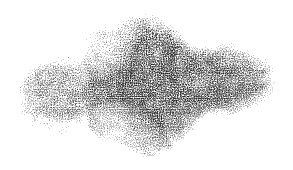

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes.set_aspect('equal')
axes.scatter(coordinates[:, 1], coordinates[:, 0], s=1, color='k', alpha=0.2, marker='.', linewidths=0.45)
axes.axis('off')

# plt.savefig(path2dir + '/figures/figure3_zebrafish/Whole_brain.png', dpi=1000)

plt.show()

Log-weight distribution weights between visible and hidden units

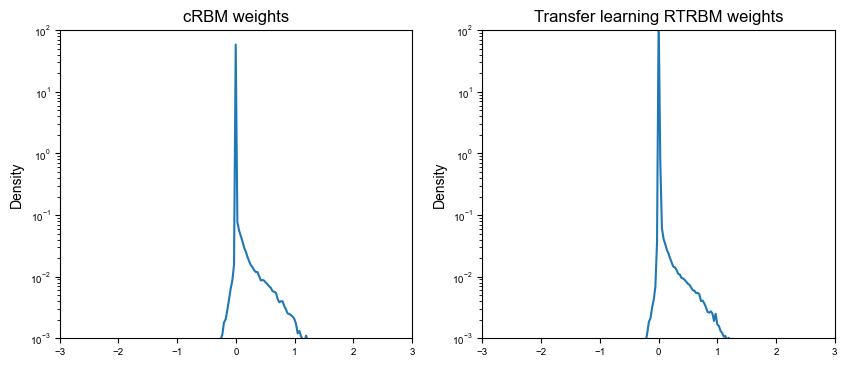

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=ax[0])
ax[0].set_ylim([1e-3, 1e2])
ax[0].set_xlim([-3, 3])
ax[0].set_title('cRBM weights')

sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10],ax=ax[1])
ax[1].set_ylim([1e-3, 1e2])
ax[1].set_xlim([-3, 3])
ax[1].set_title('Transfer learning RTRBM weights')

plt.show()

Connectivity to hidden layer

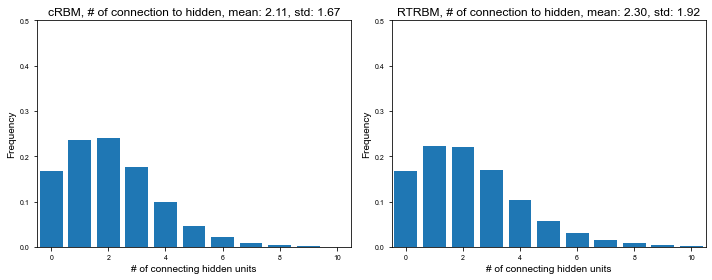

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
n = 5000
th = abs(np.sort(rbm.weights.flatten())[n])# proportional threshold
# th = min(min(np.min(np.max(np.array(rbm.weights), 1)), np.min(np.max(np.array(rtrbm.W.cpu()), 1))), th)
n_connections = np.sum(1.0 * (np.abs(rbm.weights)>th), 0)
n_connections = n_connections[n_connections<40]
n_con, freq = np.unique(n_connections, return_counts=True)
ax[0].bar(n_con, freq/sum(freq))
# sns.kdeplot(n_connections)
ax[0].set_title('cRBM, # of connection to hidden, mean: %.4s, std: %.4s'%(float(np.mean(n_connections)), float(np.std(n_connections))))
ax[0].set_xlabel('# of connecting hidden units')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim([-0.5, 10.5])
ax[0].set_ylim([0, 0.5])

th = abs(np.sort(rtrbm.W.flatten().cpu())[n])
n_connections = torch.sum(1.0 * (torch.abs(rtrbm.W.cpu())>th), 0)
n_connections = n_connections[n_connections<40]
n_con, freq = torch.unique(n_connections, return_counts=True)
ax[1].bar(n_con, freq/sum(freq))
# sns.kdeplot(n_connections)
ax[1].set_title('RTRBM, # of connection to hidden, mean: %.4s, std: %.4s'%(float(torch.mean(n_connections)), float(torch.std(n_connections))))
ax[1].set_xlabel('# of connecting hidden units')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim([-0.5, 10.5])
ax[1].set_ylim([0, 0.5])
plt.tight_layout()

# plt.savefig(path2dir + '/figures/figure3_zebrafish/Connectivity_to_hidden_layer.png', dpi=1000)

plt.show()

### Agglomerative clustering on U matrix

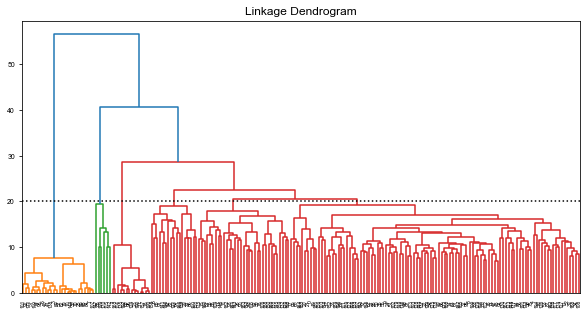

Number of unique clusters: 6


In [119]:
# Calculate the distance matrix
distance_matrix = sch.distance.pdist(rtrbm.U.cpu())

# Linkage matrix
linkage_matrix = sch.linkage(distance_matrix, method='ward')

# Choose a cutoff threshold
cutoff_height = 20

# Plot the dendrogram
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
sch.dendrogram(linkage_matrix, ax=ax)
ax.axhline(cutoff_height, c='k', linestyle=':')
ax.set_title('Linkage Dendrogram')
plt.show()

# Agglomerative clustering with a given cutoff threshold
clustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=cutoff_height)
clustering.fit(rtrbm.U.cpu())

n_clusters = len(np.unique(clustering.labels_))
print(f'Number of unique clusters: {n_clusters}')

Suggestive temporal connection between neural assemblies

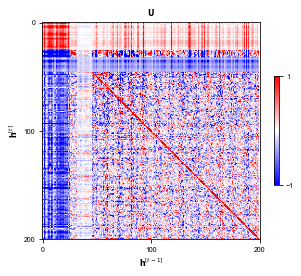

In [120]:
idx_U_sorted = np.argsort(cluster_labels)

U_ = rtrbm.U[idx_U_sorted, :].cpu().detach()
U_ = U_[:, idx_U_sorted]
W_ = rtrbm.W[idx_U_sorted, :].cpu().detach()

fig, axes = plt.subplots(1, 1, figsize=(5, 4))
cm = axes.imshow(U_, plt.get_cmap('bwr'), aspect='equal', vmin=-1, vmax=1)
cb = fig.colorbar(cm, ax=axes, shrink=.5, ticks=[-1, 1])
cb.ax.tick_params(axis='both', which='major', labelsize=7)
axes.set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=8)
axes.set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=8)
axes.set_title(r'$\mathbf{U}$', fontsize=8)
axes.set_xticks([0, 100, 200])
axes.set_xticklabels([0, 100, 200], fontsize=7)
axes.set_yticks([0, 100, 200])
axes.set_yticklabels([0, 100, 200], fontsize=7)

# plt.savefig(path2dir + '/figures/figure3_zebrafish/Temporal_connections.png', dpi=1000)
plt.show()


Characteristics of the different hidden populations defined by clustering

Total number of neurons is 43439, and participation threshold is 0.14726548
6 number of hidden units belong to segement blue and 8013 number of neurons are in the RF
17 number of hidden units belong to segement red and 2680 number of neurons are in the RF
104 number of hidden units belong to segement purple and 23001 number of neurons are in the RF
26 number of hidden units belong to segement green and 8876 number of neurons are in the RF
14 number of hidden units belong to segement yellow and 794 number of neurons are in the RF
33 number of hidden units belong to segement orange and 4576 number of neurons are in the RF


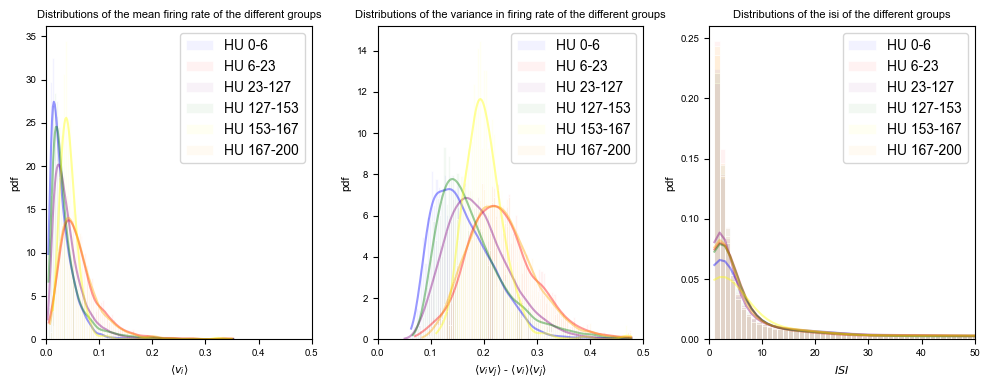

In [10]:
labels = ['blue', 'red', 'purple', 'green', 'yellow', 'orange', 'black'] # color code each cluster len(labels) should euqal nr of clusters
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
idx_U = clustering.labels_
print('Total number of neurons is %s, and participation threshold is %s'%(n_v, th))
temp_idx = 0

for c in range(n_clusters):
    idx_pseg = np.where((torch.sum(torch.abs(rtrbm.W.cpu()[np.where(idx_U == c)[0], :]) > th, 0) >= 1) == 1)[0]
    n_v_pseg = idx_pseg.shape[0]
    
    sns.histplot(data=torch.mean(1.0 * spikes[idx_pseg, :], 1), bins=100, stat='density', alpha=0.05, kde=True,
                  color=labels[c], linewidth=0.5, ax=ax[0], label='HU %s-%s'%(temp_idx, temp_idx+np.sum(idx_U== c)), edgecolor='white',
                  line_kws=dict(color='black', alpha=0.4, linewidth=1.5))
    ax[0].set_xlim([0, 0.5])
    ax[0].set_xlabel('$\langle v_i \\rangle$', fontsize=8)
    ax[0].set_ylabel('pdf', fontsize=8)
    ax[0].set_title('Distributions of the mean firing rate of the different groups', fontsize=8)
    ax[0].legend()
    
    sns.histplot(data=torch.std(1.0 * spikes[idx_pseg, :], 1), bins=100, stat='density', alpha=0.05, kde=True,
                  color=labels[c], linewidth=0.5, ax=ax[1], label='HU %s-%s'%(temp_idx, temp_idx+np.sum(idx_U== c)), edgecolor='white',
                  line_kws=dict(color='black', alpha=0.4, linewidth=1.5))
    ax[1].set_xlim([0, 0.5])
    ax[1].set_xlabel('$\langle v_iv_j \\rangle$ - $\langle v_i \\rangle$$\langle v_j \\rangle$', fontsize=8)
    ax[1].set_ylabel('pdf', fontsize=8)
    ax[1].set_title('Distributions of the variance in firing rate of the different groups', fontsize=8)
    ax[1].legend()
    
    isi = [np.diff(np.where(spike == 1)[0]) - 1 for spike in spikes[idx_pseg, :]]
    isi = np.array([item for row in isi for item in row])
    isi = isi[isi != 0]
    isi = isi[isi < 200]

    sns.histplot(data=isi, bins=200, stat='density', alpha=0.05, kde=True,
              color=labels[c], linewidth=0.5, ax=ax[2], label='HU %s-%s'%(temp_idx, temp_idx+np.sum(idx_U == c)), edgecolor='white',
              line_kws=dict(color='black', alpha=0.4, linewidth=1.5))
    ax[2].set_xlabel('$ISI$', fontsize=8)
    ax[2].set_ylabel('pdf', fontsize=8)
    ax[2].set_xlim([0, 50])
    ax[2].set_title('Distributions of the isi of the different groups', fontsize=8)
    ax[2].legend()
    temp_idx += np.sum(idx_U==c)
    print('%s number of hidden units belong to segement %s and %s number of neurons are in the RF'% (rtrbm.W.cpu()[np.where(idx_U== c)[0], :].shape[0], labels[c], n_v_pseg))
plt.tight_layout() 
plt.show()

Receptive field of hidden units (neural assemblies) color coded

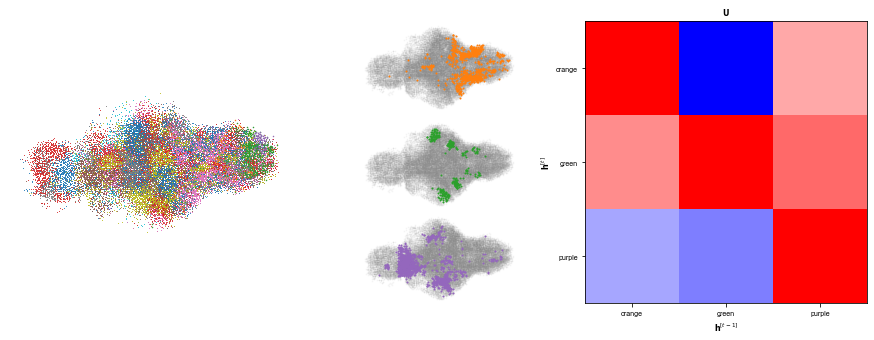

In [94]:
fig = plt.figure(constrained_layout=True, figsize=(12, 4))
gs = fig.add_gridspec(3, 3)

it_color = 0
color_list = ['tab:blue', 'tab:red', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_sub = ['tab:orange', 'tab:green', 'tab:purple']
strongest_connections = np.argmax(np.abs(W_), 0)

ax = fig.add_subplot(gs[:, 0])
ax.set_aspect('equal')

for i in range(rtrbm.n_hidden): # 200 hiddens units
    color=color_list[it_color]    
    it_color+=1
    if i % 6 == 0 and i != 0:
        it_color = 0
    try: # not all hidden units find meaningful receptive fields
        RF_hi = coordinates[torch.where((torch.abs(W_[i, :])>th))[0], :]
        #idx = coordinates[np.where(strongest_connections==h), :]
        ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=1, linewidths=0.5, color=color)
    except:
        continue
it_color = 0
for i, h in enumerate([37, 61, 62]): # 200 hiddens units, [55, 181, 61] for fish 1, used in figure 3
    
    color=color_sub[it_color]
    it_color+=1
    if i % 3 == 0 and i != 0:
        it_color = 0
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=1, linewidths=1, color=color)
ax.axis('off')
# plt.tight_layout()
# plt.gca()
# plt.savefig(path2dir + '/figures/figure3_zebrafish/Receptive_field.png', dpi=1000, transparent=True)
# plt.show()

it_color = 0


for i, h in enumerate([2, 178, 153]): # 200 hiddens units
    ax = fig.add_subplot(gs[i, 1])
    ax.set_aspect('equal')
    color=color_sub[it_color]
    it_color+=1
    if i % 3 == 0 and i != 0:
        it_color = 0
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.scatter(coordinates[:, 1], coordinates[:, 0], marker='.', s=4, linewidths=1, color='gray', alpha=.05)
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=4, linewidths=1, color=color)
    ax.axis('off')
    plt.savefig(path2dir + '/figures/figure3_zebrafish/Receptive_fields.png', dpi=1000, transparent=True)
#     plt.savefig(path2dir + '/figures/figure3_zebrafish/Receptive_field_HU_%s_.png'%h, dpi=1000, transparent=True)

ax = fig.add_subplot(gs[:, 2])
ax.set_aspect('equal')
U_subset =np.array(rtrbm.U[[2, 178, 153],:].cpu())
U_subset = U_subset[:, [2, 178, 153]]
cm = ax.imshow(U_subset, plt.get_cmap('bwr'), aspect='equal', vmin=-1, vmax=1)
cb = fig.colorbar(cm, ax=axes, shrink=.5, ticks=[-1, 1])
cb.ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([label[4:] for label in color_sub])
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([label[4:] for label in color_sub])
ax.set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=8)
ax.set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=8)
ax.set_title(r'$\mathbf{U}$', fontsize=8)

plt.show()

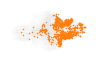

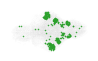

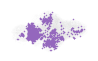

In [121]:
it_color = 0
for i, h in enumerate([2, 178, 153]): # 200 hiddens units
    fig = plt.figure(figsize=(1.5, 4/3))
    ax = plt.subplot()
    ax.set_aspect('equal')
    color=color_sub[it_color]
    it_color+=1
    if i % 3 == 0 and i != 0:
        it_color = 0
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.scatter(coordinates[:, 1], coordinates[:, 0], marker='.', s=.1, linewidths=1, color='lightgray', alpha=.05)
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=1, linewidths=1, color=color)
    ax.axis('off')
    plt.savefig(path2dir + '/figures/figure3_zebrafish/Receptive_field_HU_%s.png'%h, dpi=1000, transparent=True)

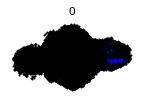

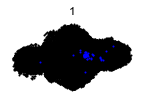

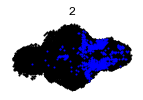

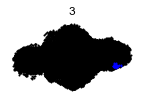

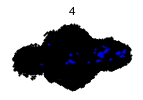

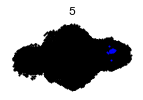

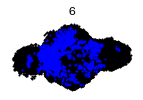

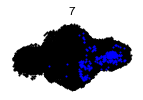

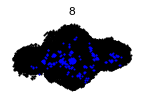

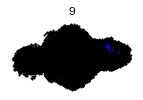

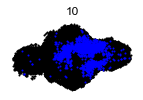

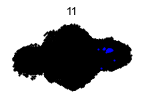

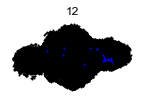

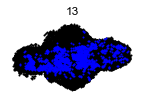

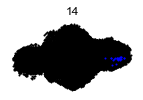

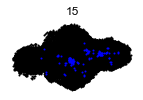

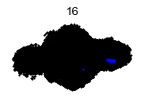

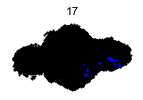

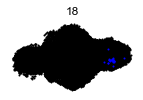

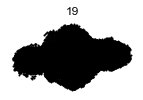

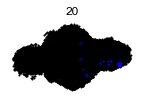

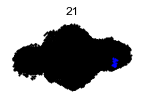

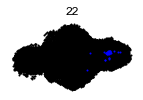

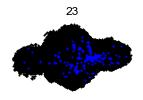

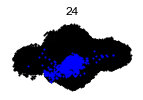

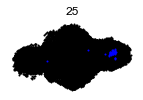

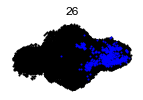

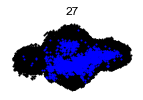

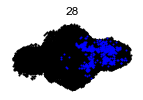

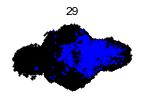

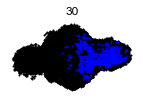

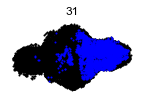

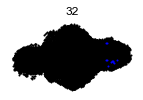

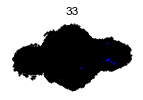

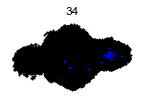

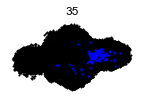

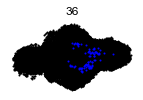

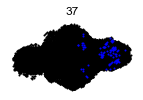

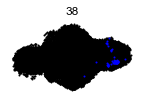

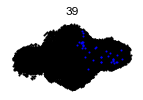

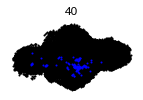

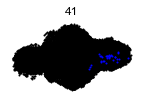

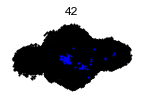

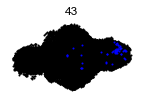

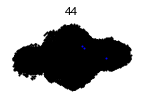

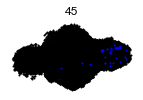

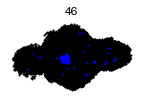

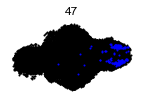

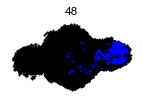

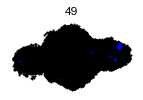

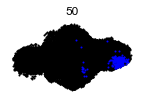

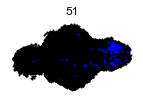

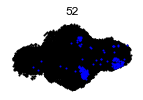

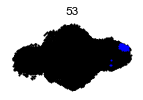

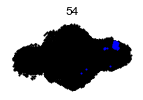

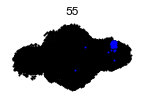

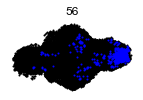

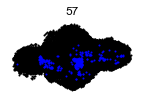

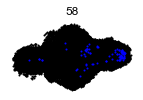

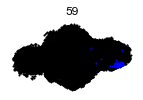

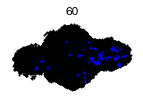

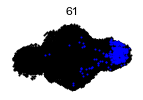

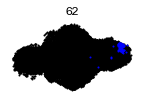

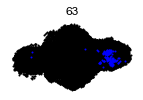

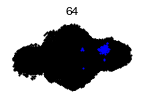

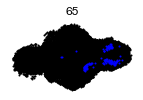

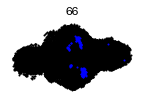

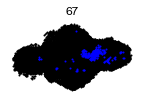

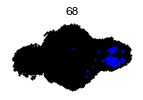

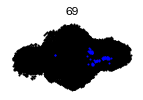

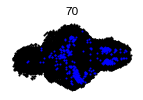

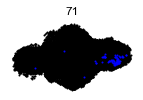

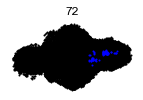

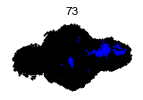

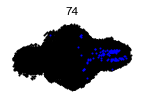

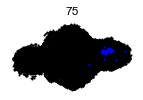

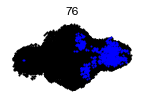

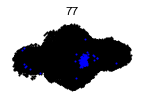

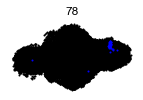

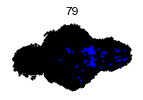

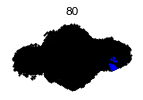

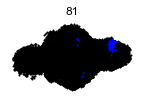

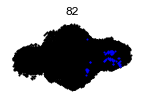

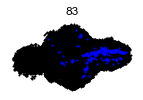

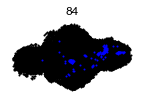

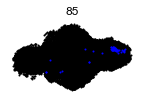

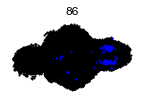

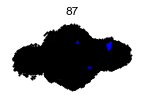

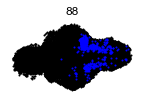

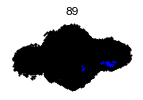

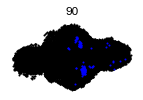

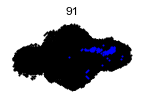

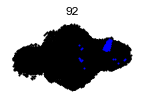

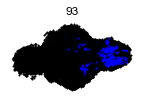

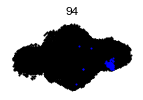

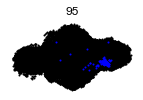

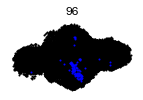

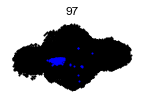

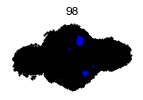

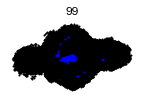

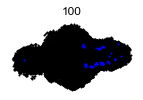

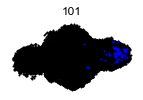

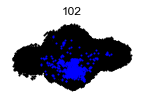

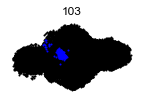

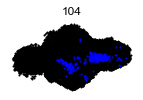

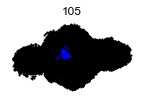

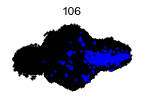

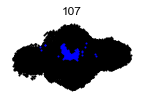

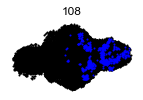

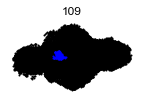

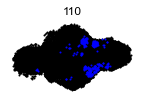

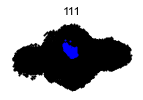

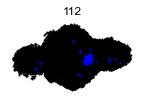

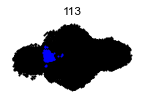

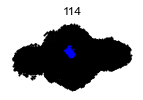

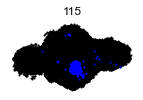

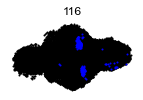

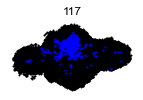

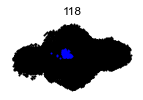

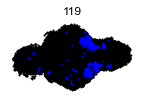

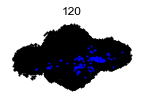

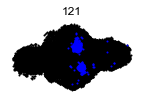

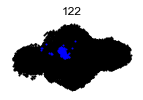

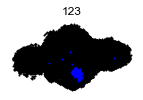

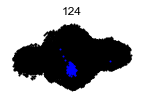

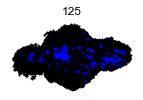

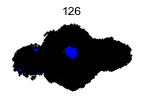

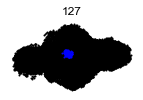

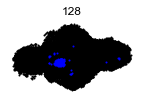

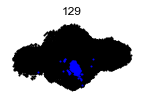

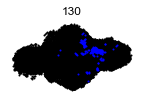

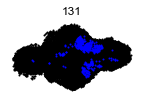

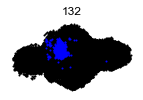

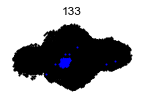

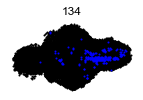

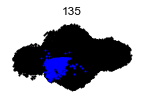

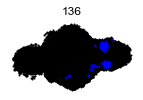

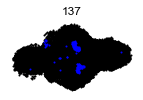

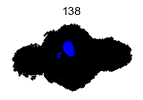

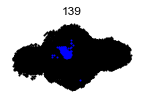

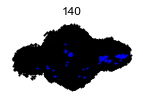

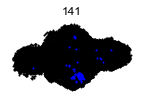

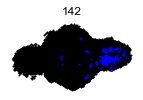

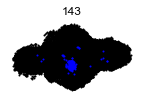

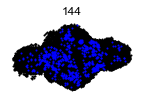

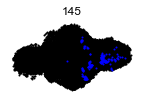

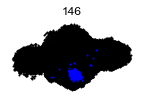

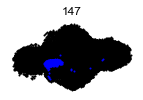

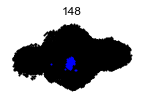

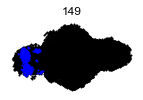

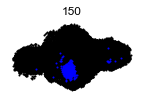

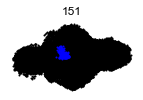

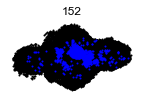

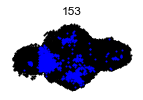

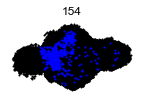

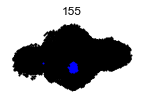

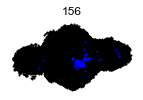

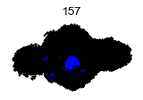

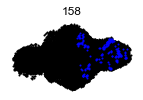

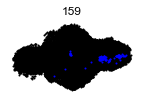

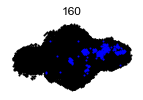

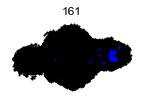

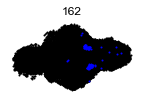

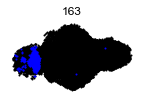

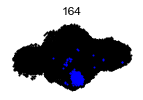

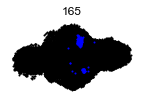

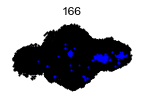

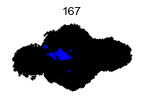

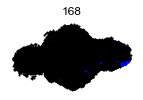

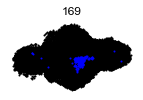

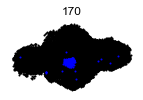

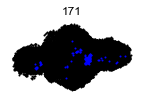

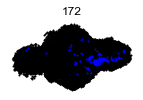

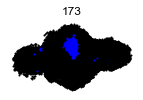

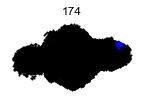

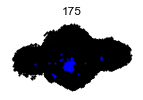

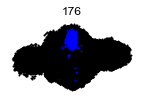

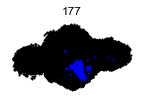

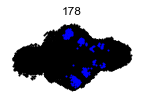

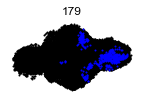

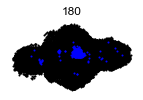

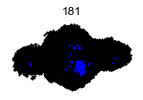

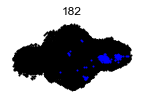

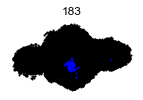

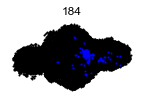

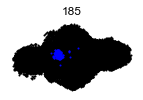

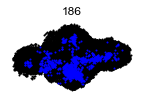

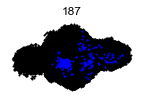

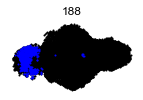

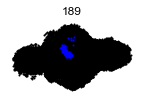

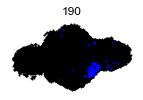

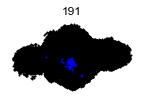

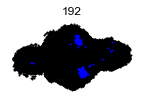

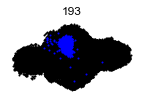

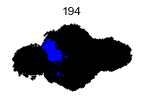

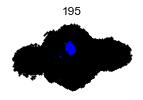

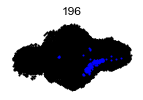

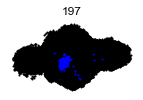

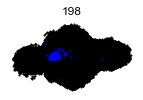

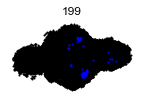

In [93]:
for i, h in enumerate(np.arange(200)): # 200 hiddens units
    fig = plt.figure(figsize=(4, 4/3))
    ax = plt.subplot()
    ax.set_aspect('equal')
    RF_hi = coordinates[torch.where((torch.abs(W_[h, :])>th))[0], :]
    #idx = coordinates[np.where(strongest_connections==h), :]
    ax.scatter(coordinates[:, 1], coordinates[:, 0], marker='.', s=4, linewidths=1, color='k')
    ax.scatter(RF_hi[:, 1], RF_hi[:, 0], marker='.', s=4, linewidths=1, color='b')
    ax.axis('off')
    ax.set_title(h)
    plt.show()

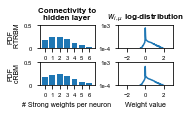

In [115]:
plt.rcParams["font.family"] = "Arial"
fig, axes = plt.subplots(2, 2, figsize=(2.6, 1.7))
fs=7
n=5000

th = abs(np.sort(rtrbm.W.flatten().cpu())[n])
n_connections = torch.sum(1.0 * (torch.abs(rtrbm.W.cpu())>th), 0)
n_connections = n_connections[n_connections<7]
n_con, freq = np.unique(n_connections, return_counts=True)
axes[0, 0].bar(n_con, freq/sum(freq))
axes[0, 0].set_title('Connectivity to\nhidden layer', fontsize=8, fontweight='bold')
axes[0, 0].tick_params(axis='both', which='major', labelsize=6)
axes[0, 0].set_xticks(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[0, 0].set_xticklabels(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[0, 0].set_ylim(0, .45)
axes[0, 0].set_yticks([0, 0.45])
axes[0, 0].set_yticklabels(['0', '0.5'])
axes[0, 0].set_ylabel('PDF\n RTRBM', fontsize=7)

# axes[0, 1].set_box_aspect(1)


g = sns.kdeplot(rtrbm.W.ravel().cpu(), log_scale=[0, 10], ax=axes[0, 1])
g.set(ylabel=None)
axes[0, 1].set_xlim([-3, 3])
axes[0, 1].set_ylim([1e-4, 1e3])
axes[0, 1].set_yticks([1e-4, 1e3])
axes[0, 1].set_yticklabels(['1e-4', '1e3'])
axes[0, 1].set_title(r'$w_{i, \mu}$ log-distribution', fontsize=8, fontweight='bold')
axes[0, 1].tick_params(axis='both', which='major', labelsize=6)
# axes[0, 0].set_box_aspect(1)

n_connections = np.sum(1.0 * (np.abs(rbm.weights)>th), 0)
n_connections = n_connections[n_connections<7]
n_con, freq = np.unique(n_connections, return_counts=True)
axes[1, 0].bar(n_con, freq/sum(freq))
axes[1, 0].set_xlabel('# Strong weights per neuron ', fontsize=7)
axes[1, 0].tick_params(axis='both', which='major', labelsize=6)
axes[1, 0].set_xticks(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[1, 0].set_xticklabels(np.arange(np.max(np.array(n_con, dtype=int) + 1)))
axes[1, 0].set_ylim(0, .45)
axes[1, 0].set_yticks([0, 0.45])
axes[1, 0].set_yticklabels(['0', '0.5'])
axes[1, 0].set_ylabel('PDF\n cRBM', fontsize=7)

# axes[1, 1].set_box_aspect(1)

th = abs(np.sort(rbm.weights.flatten())[n])
g = sns.kdeplot(rbm.weights.ravel(), log_scale=[0, 10], ax=axes[1, 1])
g.set(ylabel=None)
axes[1, 1].set_xlim([-3, 3])
axes[1, 1].set_ylim([1e-4, 1e3])
axes[1, 1].set_yticks([1e-4, 1e3])
axes[1, 1].set_yticklabels(['1e-4', '1e3'])
axes[1, 1].set_xlabel('Weight value', fontsize=7)
axes[1, 1].tick_params(axis='both', which='major', labelsize=6)
# axes[1, 0].set_box_aspect(1)


plt.tight_layout(h_pad=0, w_pad=0.4)
plt.savefig(path2dir + '/figures/figure3_zebrafish/W_stats.png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [132]:
fs=7
n=5000

th = abs(np.sort(rtrbm.W.flatten().cpu())[n])
th

0.052859113

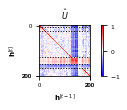

In [116]:
idx_U_sorted = np.argsort(clustering.fit_predict(rtrbm.U.cpu()))
U_ = rtrbm.U[idx_U_sorted, :].cpu().detach()
U_ = U_[:, idx_U_sorted]
W_ = rtrbm.W[idx_U_sorted, :].cpu().detach()

fig, axes = plt.subplots(1, 1, figsize=(2, 1.4))
cm = axes.imshow(U_, plt.get_cmap('bwr'), aspect='equal', vmin=-1, vmax=1)
cb = fig.colorbar(cm, ax=axes, shrink=1, ticks=[-1, 0, 1], pad=.1)
cb.minorticks_off()
cb.ax.set_yticklabels(['$-1$', '$0$', '$1$'], fontsize=6)
axes.set_xlabel(r'$\mathbf{h}^{[t-1]}$', fontsize=7)
axes.set_ylabel(r'$\mathbf{h}^{[t]}$', fontsize=7)
axes.set_title(r'$\hat{U}$', fontsize=8)
axes.set_xticks([0, 200, 200])
axes.set_xticklabels([0, 200, 200], fontsize=6)
axes.set_yticks([0, 200, 200])
axes.set_yticklabels([0, 200, 200], fontsize=6)

u, c = np.unique(clustering.labels_, return_counts=True)
c_cumsum = np.cumsum(c)
for c_i in range(n_clusters):
#     axes.text(x=205, y=c_cumsum[c_i]-c[c_i]//3, s=f'$c_{c_i+1}$', c='k', fontsize=10)
    axes.axhline(c_cumsum[c_i], linestyle=':', c='k', lw=1)
plt.tight_layout(pad=.25, w_pad=0)
plt.show()

fig.savefig(path2dir + '/figures/figure3_zebrafish/U_hat.png', dpi=250, transparent=True)

C:\Users\luukh\anaconda3\envs\multifish_squared\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: All-NaN slice encountered


0 -3
1 -2
2 -1
3 0
4 1
5 2


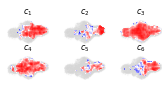

In [133]:
from matplotlib.collections import QuadMesh
import math
from scipy.spatial import KDTree

rad = .015 #um
dens_samp = .0025 #um

 
group_idx = clustering.labels_
sorted_group_idx = np.sort(group_idx)
sorted_idx = np.argsort(group_idx)
fig = plt.figure(figsize=(3.7, 1))
gs = gridspec.GridSpec(2, 3)


dim_ranges = [[np.min(c), np.max(c)] for c in coordinates.T]
dim_bins = [np.linspace(r[0], r[1], math.floor((r[1]-r[0])/dens_samp)) for r in dim_ranges]

for c_i in range(6):
#     th = abs(np.sort((rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]).flatten().cpu())[10])
    
    idx_pseg = np.where((torch.sum(torch.abs(rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]) > th, 0) >= 1) == 1)[0]
#     print(th, idx_pseg.shape)
    # Create density map using KDTree for efficient calculation
    kdtree = KDTree(coordinates[idx_pseg])
    X = np.stack(np.meshgrid(*dim_bins, indexing='ij'))
    X = X.reshape(3, np.prod([len(b) for b in dim_bins]))
    density_map = np.array([len(p) for p in kdtree.query_ball_point(X.T, r=rad, p=2)], dtype=float)
    density_map = density_map.reshape([len(b) for b in dim_bins])
    density_map[density_map==0] = np.nan
    density_map_proj = np.nanmax(density_map, axis=2)
    
#     if c_i <= 3:
#         ax = plt.subplot(gs[0, c_i*2:c_i*2+2])
#     elif c_i > 3:
#         ax = plt.subplot(gs[1, 1+(c_i-4)*2:1+(c_i-4)*2+2])
    print(c_i, c_i-3)
    if c_i <= 2:
        ax = plt.subplot(gs[0, c_i])
    elif c_i > 2:
        ax = plt.subplot(gs[1, c_i-3])
    ax.set_aspect('equal')
    ax.scatter(coordinates[:, 1], coordinates[:, 0],
               s=1, color='lightgray', alpha=0.05, marker='.')
    ax.imshow(np.flip(density_map_proj, axis=0), cmap='bwr', norm=mcolors.LogNorm(vmin=1, vmax=None),
               extent=[dim_bins[1][0], dim_bins[1][-1], dim_bins[0][0], dim_bins[0][-1]],
               zorder=10)
    ax.axis('off')    
    ax.set_title(f'$c_{c_i+1}$', fontsize=8)
    
plt.tight_layout(pad=0, w_pad=-8)
plt.show()

fig.savefig(path2dir + '/figures/figure3_zebrafish/U_clusters_density.png', dpi=1000, transparent=True)

### Rasterplot

In [106]:
th = abs(np.sort(rtrbm.W.flatten().cpu())[1000])
idx_pseg = []
for c_i in range(2):
    cur_idx_pseg = np.where((torch.sum(torch.abs(rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]) > th, 0) >= 1) == 1)[0]
    idx_pseg += [cur_idx_pseg]
    
    for i, li in enumerate(idx_pseg[:-1]):
        idx_dup = np.intersect1d(li, cur_idx_pseg)
        r = rtrbm.W.cpu()[:, idx_dup]
        del_idx = r[np.where(group_idx == c_i)[0], :] < r[np.where(group_idx == i)[0], :]
        idx_pseg[c_i].remove(del_idx)
        idx_pseg[i].remove(~del_idx)

RuntimeError: The size of tensor a (17) must match the size of tensor b (6) at non-singleton dimension 0

In [112]:
(r[np.where(group_idx == c_i)[0], :]) < (r[np.where(group_idx == i)[0], :])

RuntimeError: The size of tensor a (17) must match the size of tensor b (6) at non-singleton dimension 0

In [110]:
r[np.where(group_idx == i)[0], :]

tensor([[ 5.6429e-07,  1.1081e-03,  2.8081e-07,  ..., -7.3021e-07,
          9.2246e-07,  5.6252e-03],
        [ 2.6545e-01,  4.7845e-01,  6.0050e-07,  ...,  3.7958e-03,
          5.8536e-01,  9.4977e-01],
        [ 6.1131e-08,  1.4164e-02, -2.3730e-07,  ...,  4.3194e-02,
         -4.8902e-07,  8.0334e-03],
        [ 1.3540e-02, -1.2071e-06,  5.6864e-07,  ...,  3.1268e-02,
          5.2235e-07,  1.1995e-06],
        [ 8.4891e-07,  9.2024e-08, -2.4969e-01,  ...,  2.5644e-01,
         -6.1976e-07,  1.1129e-02],
        [ 1.4502e-02,  1.8983e-06,  7.5806e-07,  ...,  4.1895e-02,
         -3.3004e-06, -1.0104e-06]])

In [42]:
th = abs(np.sort(rtrbm.W.flatten().cpu())[1000])
idx_pseg = []
for c_i in range(n_clusters):
    idx_pseg += np.where((torch.sum(torch.abs(rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]) > th, 0) >= 1) == 1)[0]
    
    for li in idx_pseg[:-1]:
        idx_dup = torch.unique(li, idx_pseg)
            
    
    # flatten list and look for duplicates
    unique_idx, count = torch.unique(torch.concatenate(idx_pseg).ravel())
    
    
    for ls in s:
        for ss in s[ls]:
            idx 
    
    s += [spikes[idx_pseg, :]]

    

In [80]:
th = abs(np.sort(rtrbm.W.flatten().cpu())[1000])
s = []
length_cluster = torch.zeros(n_clusters)
for c_i in range(n_clusters):
#     th = abs(np.sort((rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]).flatten().cpu())[10])
    idx_pseg = np.where((torch.sum(torch.abs(rtrbm.W.cpu()[np.where(group_idx == c_i)[0], :]) > th, 0) >= 1) == 1)[0]
    s += [spikes[idx_pseg, :]]
    
    
#     length_cluster[c_i] = s[c_i].shape[0]



In [75]:
length_cluster = torch.cumsum(length_cluster, 0, dtype=int)

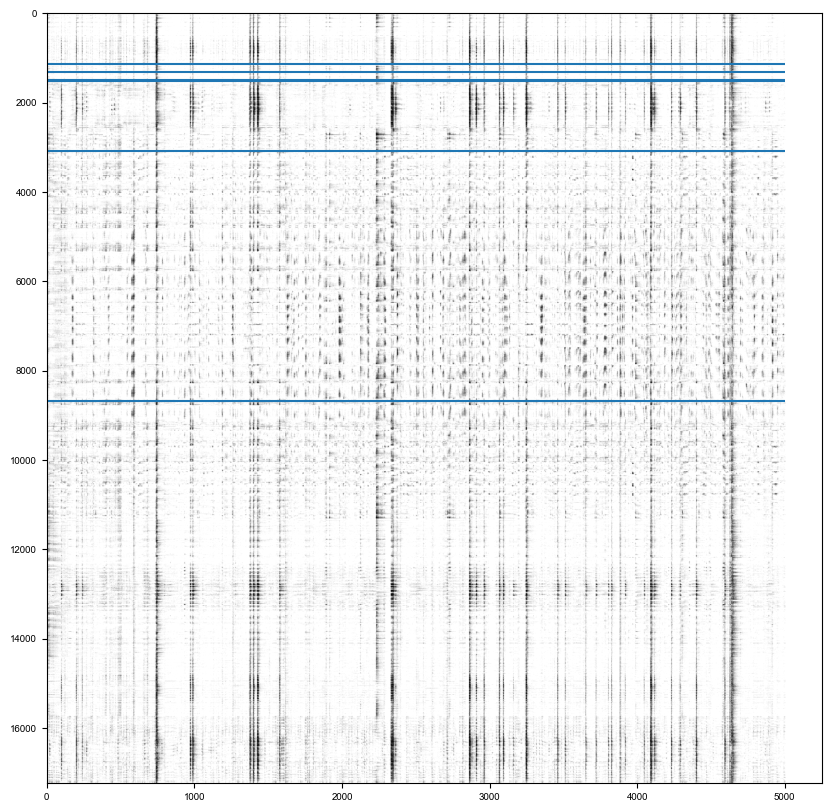

In [86]:
# s = torch.concatenate(s)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(s, cmap=plt.get_cmap('binary'), aspect='auto')
ax.hlines(length_cluster, xmin=0, xmax=s.shape[1])

### Moments plot


According to the cRBM paper methodology, the data is arranged chronologically into 10 batches. Batch 2, 6, and 7 are designated as the test set, while the remaining batches are assigned to the train set. Therefore, the dataset is split into train and test sets following this protocol.

In [ ]:
def train_test_split(data):
    batch_size = data.shape[1] // 10
    train = torch.zeros(data.shape[0], batch_size, 7)
    test = torch.zeros(data.shape[0], batch_size, 3)
    batch_index_shuffled = [0, 2, 3, 4, 7, 8, 9, 1, 5, 6]
    i = 0

    for batch in range(10):
        j = batch_index_shuffled[batch]
        if batch < 7:
            train[:, :, batch] = data[:, j * batch_size:(j + 1) * batch_size]
        if batch >= 7:
            test[:, :, batch-7] = data[:, j * batch_size:(j + 1) * batch_size]

    return train, test


C:\Users\sebas\AppData\Local\Temp\ipykernel_17600\1528252521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, test = train_test_split(torch.tensor(spikes))


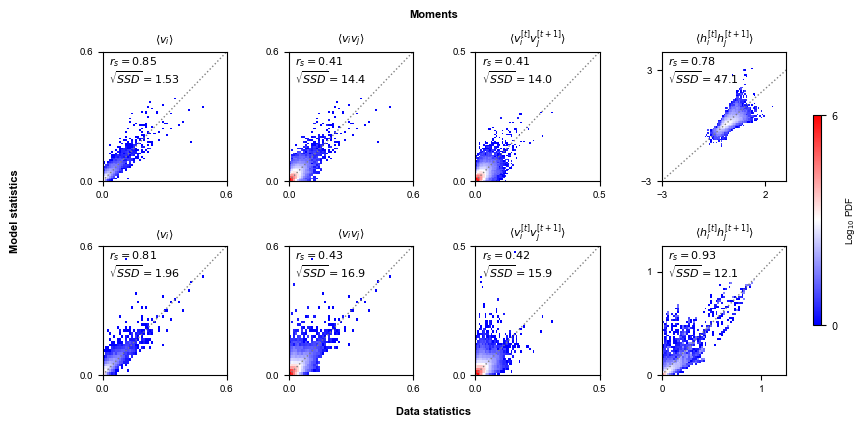

In [165]:
run = 1
_, test = train_test_split(torch.tensor(spikes))
if not os.path.isfile(path2dir + 'inferred/figure3_zebrafish/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, run)):
    
    _, test = train_test_split(torch.tensor(spikes.T))
    test = reshape(reshape(test), T=T[dataset], n_batches=n_batches_test[dataset])
    vs_rtrbm, hs_rtrbm = rtrbm.sample(test[:, 0, :].to(rtrbm.device), chain=test.shape[1], pre_gibbs_k=4000,
                            gibbs_k=10, disable_tqdm=True)
    vs_cRBM, hs_cRBM = RBM.gen_data(
        Lchains = T[dataset], # Length of MCMC chains,
        Nchains = n_batches_test[dataset], # Number of MCMC chains,
        Nthermalize = 4000, # Number of burn-in MCMC steps
        Nstep = 20 # Number of steps between saved MCMC points
        )
    vs_cRBM, hs_cRBM = vs_cRBM.T, hs_cRBM.T
    torch.save([vt, vs_rtrbm, torch.tensor(vs_cRBM), hs_rtrbm, torch.tensor(hs_cRBM)], path2dir + 'inferred/figure3_zebrafish/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, run))
else:
    vt, vs_rtrbm, vs_cRBM, hs_rtrbm, hs_cRBM = torch.load(path2dir + 'inferred/figure3_zebrafish/fish%s/vt_vsrtrbm_vscRBM_hsrtrbm_hscRBM_run%s'%(dataset_idx+1, run))

ht_cRBM = rbm.mean_hiddens(reshape(vt).T).T
ht_rtrbm = rtrbm._parallel_recurrent_sample_r_given_v(vt.to(rtrbm.device))

plot_moments(vt, vs_cRBM, vs_rtrbm, ht_cRBM, ht_rtrbm, hs_cRBM, hs_rtrbm, return_stats=False, n_neurons=10000)
plt.show()